In [4]:
#toy experiments for GANs with different loss scoring functions for the adversarial game

from argparse import ArgumentParser
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
import random

In [5]:
lr = 1e-4
n_epochs = 25
batch_size = 32
noise_dim = 32
img_dim = 28 * 28 * 1
hidden_size = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        layers = [
            nn.Linear(noise_dim, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, img_dim),
        ]
        
        layers.append(nn.Tanh())
        
        self.model = nn.Sequential(*layers)

    def forward(self, z):
        return self.model(z)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, hidden_size),
            nn.LeakyReLU(0.02),
            #nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.02),
            #nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        return self.model(flattened)

In [27]:
def brier_score_loss(d_outputs_real, d_outputs_fake):
    return torch.mean((1.0 - d_outputs_real) ** 2) + torch.mean(d_outputs_fake ** 2)

def hinge_loss(d_outputs_real, d_outputs_fake):
    loss_real = torch.mean(torch.relu(1.0 - d_outputs_real))
    loss_fake = torch.mean(torch.relu(1.0 + d_outputs_fake))
    return loss_real + loss_fake

def exponential_loss(d_outputs_real, d_outputs_fake):
    loss_real = torch.mean(torch.exp(-d_outputs_real))
    loss_fake = torch.mean(torch.exp(d_outputs_fake))
    return loss_real + loss_fake

def spherical_loss(d_outputs_real, d_outputs_fake):
    loss_real = torch.mean(1 - torch.sqrt(1 - torch.minimum(d_outputs_real**2, torch.tensor(1.0).to(device))))
    loss_fake = torch.mean(1 - torch.sqrt(1 - torch.minimum(d_outputs_fake**2, torch.tensor(1.0).to(device))))
    return loss_real + loss_fake

def train_gan(n_epochs, train_loader): 
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    optim_d = optim.Adam(discriminator.parameters(), lr=2e-4)
    optim_g = optim.Adam(generator.parameters(), lr=2e-4)

    criterion = nn.BCELoss()
    d_losses, g_losses = [], []
    for epoch in range(n_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            current_batch_size = real_images.size(0)

            real_labels = torch.ones(current_batch_size, 1).to(device)
            fake_labels = torch.zeros(current_batch_size, 1).to(device)

            real_images = real_images.to(device)
            real_images = real_images.view(current_batch_size, -1)

            optim_d.zero_grad()

            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(current_batch_size, noise_dim).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())  
            d_loss_fake = brier_score_loss(torch.ones_like(outputs), outputs)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            optim_d.step()

            optim_g.zero_grad()

            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()

            optim_g.step()
            d_loss = d_loss_real + d_loss_fake
            d_losses.append(d_loss.item())

            g_loss = criterion(outputs, real_labels)
            g_losses.append(g_loss.item())

            if (i + 1) % 1800 == 0:
                print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{len(train_loader)}], '
                    f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

    print('Training finished.')

    plt.figure(figsize=(10, 5))
    plt.title("g & d loss during training")
    plt.plot(g_losses, label="g loss")
    plt.plot(d_losses, label="d loss")

    plt.xlabel("itrs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    return d_losses, g_losses, generator

In [11]:
d_losses, g_losses, _ = train_gan(n_epochs, train_loader)

plt.figure(figsize=(15, 8))

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)

window_size = 250 
d_losses_moving_avg = moving_average(d_losses, window_size)
g_losses_moving_avg = moving_average(g_losses, window_size)

plt.figure(figsize=(10, 5))
plt.title("g & d loss during GAN training")

plt.plot(d_losses, label="d loss", alpha=0.3)
plt.plot(g_losses, label="g loss", alpha=0.3)

plt.plot(d_losses_moving_avg, color="blue")
plt.plot(g_losses_moving_avg, color="orange")

plt.xlabel("itrs")
plt.ylabel("loss")
plt.legend()
plt.show()

KeyboardInterrupt: 

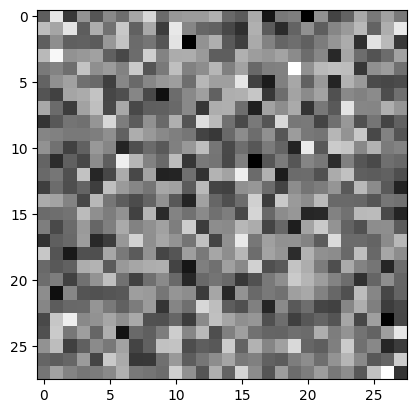

In [57]:
generator = Generator() 
generator.eval()   

with torch.no_grad():   
    noise = torch.randn(batch_size, noise_dim).to(device)

    generated_images = generator(noise)

    generated_images = (generated_images + 1) / 2  
    generated_images = generated_images.clamp(0, 1)   

image = generated_images[0].cpu().view(28, 28).numpy()  

plt.imshow(image, cmap='gray')
plt.show()

In [35]:
def gradient_norms(generator, train_loader, n_iters): 
    generator.eval()
    discriminator = Discriminator().to(device)

    optim_d = optim.Adam(discriminator.parameters(), lr=2e-4)
    criterion = nn.BCELoss()
    grad_norm_list = []

    for itr in range(n_iters):
        for real_images, _ in train_loader:
            real_images = real_images.to(device)
            real_images = real_images.view(real_images.size(0), -1)
            real_labels = torch.ones(real_images.size(0), 1).to(device)
            fake_labels = torch.zeros(real_images.size(0), 1).to(device)

            optim_d.zero_grad()

            real_outputs = discriminator(real_images)
            d_loss_real = criterion(real_outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(real_images.size(0), noise_dim).to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(fake_outputs, fake_labels)
            d_loss_fake.backward()

            optim_d.step()

            total_norm = 0
            for p in discriminator.parameters():
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            grad_norm_list.append(total_norm)

            if itr >= n_iters:
                break

        if itr >= n_iters:
            break

    return grad_norm_list

Epoch [1/1], Step [1800/1875], D Loss: 0.0282, G Loss: 3.8232
Training finished.


<Figure size 1000x500 with 0 Axes>

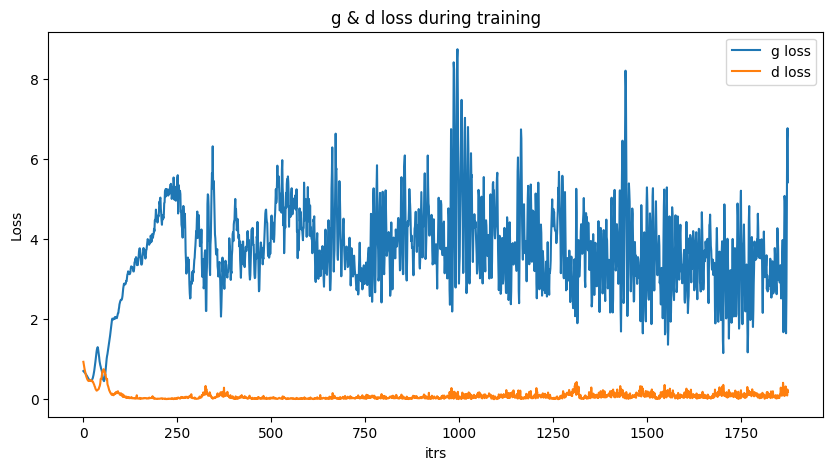

Epoch [1/10], Step [1800/1875], D Loss: 0.0520, G Loss: 5.8070
Epoch [2/10], Step [1800/1875], D Loss: 0.4126, G Loss: 2.5244
Epoch [3/10], Step [1800/1875], D Loss: 0.1279, G Loss: 2.7623
Epoch [4/10], Step [1800/1875], D Loss: 0.2124, G Loss: 2.0258
Epoch [5/10], Step [1800/1875], D Loss: 0.2313, G Loss: 2.2127
Epoch [6/10], Step [1800/1875], D Loss: 0.3114, G Loss: 2.4492
Epoch [7/10], Step [1800/1875], D Loss: 0.3060, G Loss: 1.7418
Epoch [8/10], Step [1800/1875], D Loss: 0.4344, G Loss: 2.5162
Epoch [9/10], Step [1800/1875], D Loss: 0.4564, G Loss: 1.6404
Epoch [10/10], Step [1800/1875], D Loss: 0.4559, G Loss: 0.9318
Training finished.


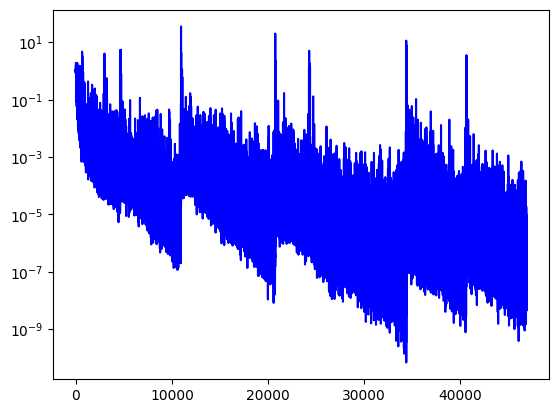

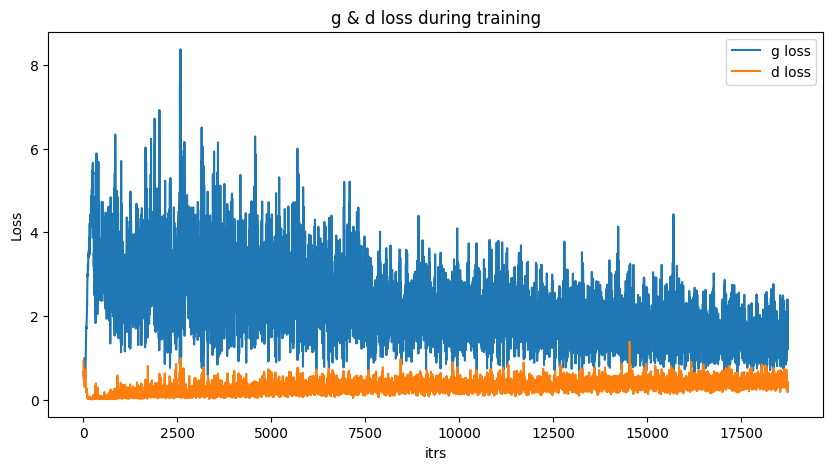

Epoch [1/25], Step [1800/1875], D Loss: 0.1039, G Loss: 2.2448
Epoch [2/25], Step [1800/1875], D Loss: 0.1435, G Loss: 2.5922
Epoch [3/25], Step [1800/1875], D Loss: 0.3069, G Loss: 2.2330
Epoch [4/25], Step [1800/1875], D Loss: 0.4122, G Loss: 1.6025
Epoch [5/25], Step [1800/1875], D Loss: 0.4220, G Loss: 2.1081
Epoch [6/25], Step [1800/1875], D Loss: 0.2852, G Loss: 1.7246
Epoch [7/25], Step [1800/1875], D Loss: 0.3600, G Loss: 1.3845
Epoch [8/25], Step [1800/1875], D Loss: 0.4138, G Loss: 1.4102
Epoch [9/25], Step [1800/1875], D Loss: 0.4944, G Loss: 0.7389
Epoch [10/25], Step [1800/1875], D Loss: 0.6379, G Loss: 0.8936
Epoch [11/25], Step [1800/1875], D Loss: 0.2704, G Loss: 1.4870
Epoch [12/25], Step [1800/1875], D Loss: 0.5670, G Loss: 0.9995
Epoch [13/25], Step [1800/1875], D Loss: 0.5001, G Loss: 1.1966
Epoch [14/25], Step [1800/1875], D Loss: 0.5040, G Loss: 1.2267
Epoch [15/25], Step [1800/1875], D Loss: 0.6221, G Loss: 0.8510
Epoch [16/25], Step [1800/1875], D Loss: 0.4529, 

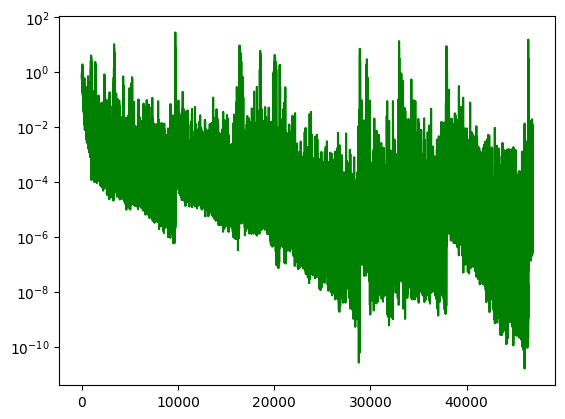

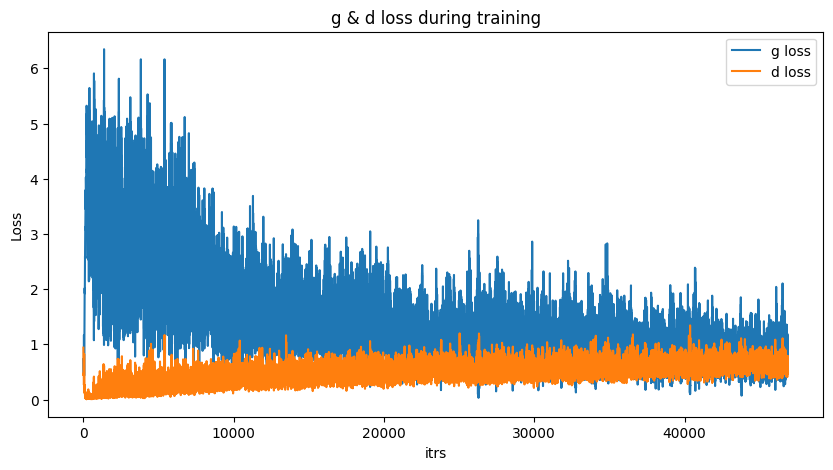

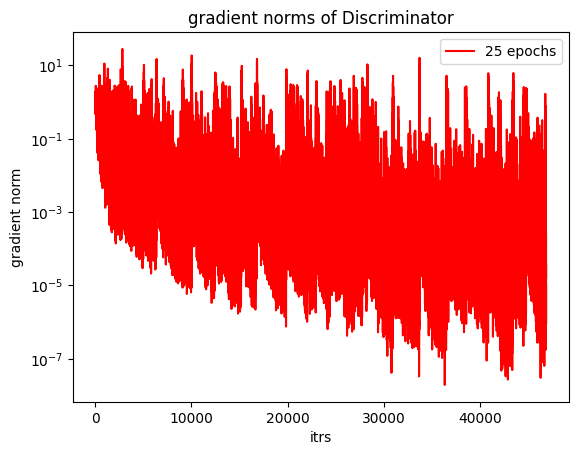

In [59]:
n_iters = 25
epochs_to_train = [1, 10, 25] 
grad_norm_list = []
colors = ['blue', 'green', 'red']

plt.figure(figsize=(10, 5))

for idx, epochs in enumerate(epochs_to_train):
    _, _, trained_generator = train_gan(epochs, train_loader)  
    grad_norms = gradient_norms(trained_generator, train_loader, n_iters)
    grad_norm_list.append(grad_norms)
    plt.yscale('log') 
    plt.plot(grad_norm_list[-1], label=f"{epochs} epochs", color = colors[idx]) 
    

plt.yscale('log') 
plt.title("gradient norms of Discriminator")
plt.xlabel("itrs")
plt.ylabel("gradient norm")
plt.legend()
plt.show()

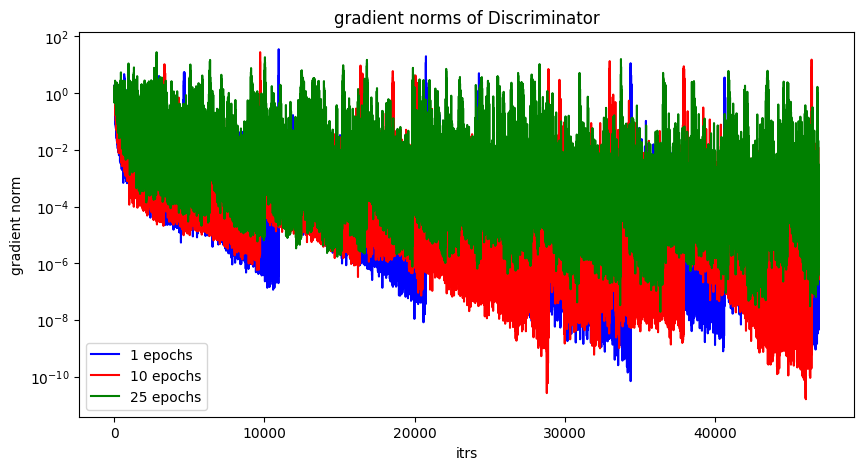

In [67]:
epochs_to_train = [1, 10, 25]
colors = ['blue', 'red', 'green']

plt.figure(figsize=(10, 5))

for idx, grad_norms in enumerate(grad_norm_list):
    plt.yscale('log')   
    plt.plot(grad_norms, label=f"{epochs_to_train[idx]} epochs", color=colors[idx])

plt.yscale('log')   
plt.title("gradient norms of Discriminator")
plt.xlabel("itrs")
plt.ylabel("gradient norm")
plt.legend()
plt.show()


In [68]:
def calculate_accuracy(discriminator, real_images, fake_images):
    with torch.no_grad():
        real_predictions = discriminator(real_images)
        fake_predictions = discriminator(fake_images)

        real_correct = real_predictions > 0.5
        fake_correct = fake_predictions <= 0.5
        accuracy = (real_correct.sum().item() + fake_correct.sum().item()) / (real_images.size(0) + fake_images.size(0))
    return accuracy

In [73]:
def accuracy_discriminator(epochs, train_loader):
    _, _, trained_generator = train_gan(epochs, train_loader)

    discriminator = Discriminator().to(device)
    optim_d = torch.optim.Adam(discriminator.parameters(), lr=2e-4)

    accuracies = []

    for real_images, _ in train_loader:
        real_images = real_images.to(device)
        real_images = real_images.view(real_images.size(0), -1)

        z = torch.randn(real_images.size(0), noise_dim).to(device) 
        fake_images = trained_generator(z)

        accuracy = calculate_accuracy(discriminator, real_images, fake_images)
        accuracies.append(accuracy)

        discriminator.train()
        optim_d.zero_grad()
        criterion = nn.BCELoss()
        real_loss = criterion(discriminator(real_images), torch.ones(real_images.size(0), 1).to(device))
        fake_loss = criterion(discriminator(fake_images.detach()), torch.zeros(real_images.size(0), 1).to(device))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_d.step()

    return accuracies

Epoch [1/1], Step [1800/1875], D Loss: 0.0703, G Loss: 3.3690
Training finished.


<Figure size 1000x500 with 0 Axes>

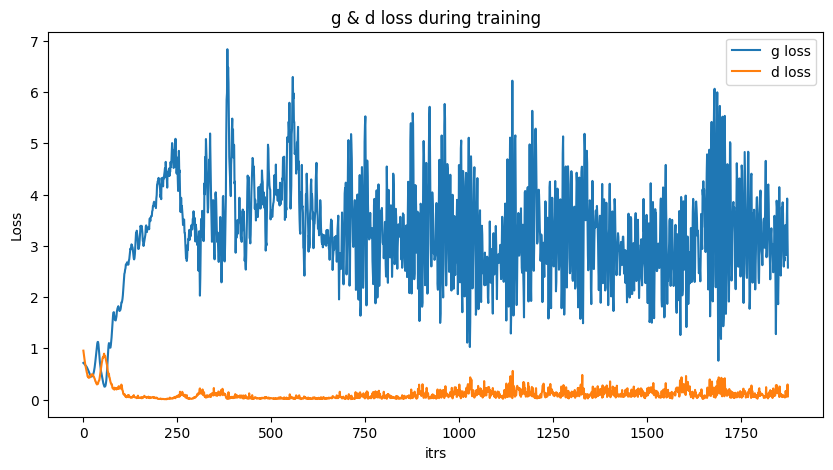

Epoch [1/10], Step [1800/1875], D Loss: 0.1087, G Loss: 2.6405
Epoch [2/10], Step [1800/1875], D Loss: 0.4021, G Loss: 3.1047
Epoch [3/10], Step [1800/1875], D Loss: 0.1393, G Loss: 2.2551
Epoch [4/10], Step [1800/1875], D Loss: 0.2536, G Loss: 3.0176
Epoch [5/10], Step [1800/1875], D Loss: 0.2768, G Loss: 2.1878
Epoch [6/10], Step [1800/1875], D Loss: 0.4024, G Loss: 1.9157
Epoch [7/10], Step [1800/1875], D Loss: 0.4096, G Loss: 1.4565
Epoch [8/10], Step [1800/1875], D Loss: 0.2878, G Loss: 2.3938
Epoch [9/10], Step [1800/1875], D Loss: 0.3862, G Loss: 1.3784
Epoch [10/10], Step [1800/1875], D Loss: 0.2566, G Loss: 2.4144
Training finished.


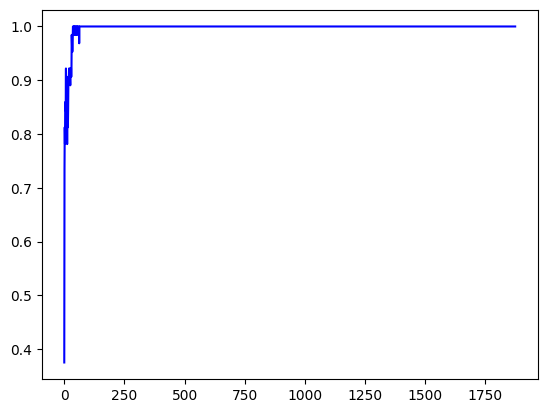

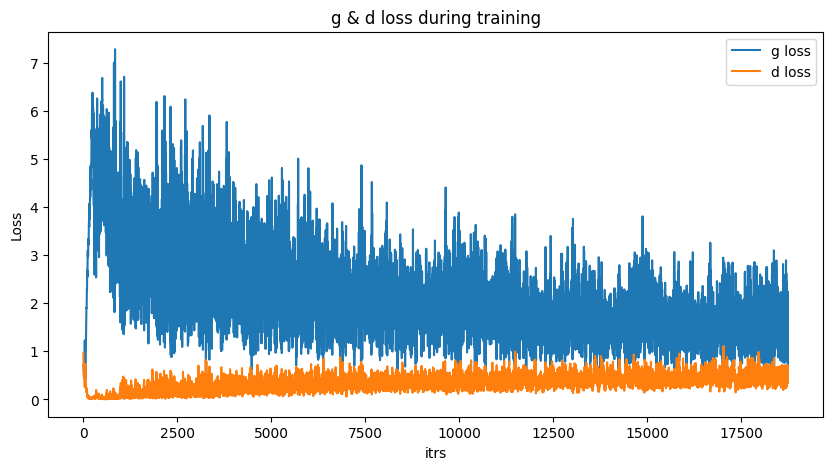

Epoch [1/25], Step [1800/1875], D Loss: 0.1657, G Loss: 3.0965
Epoch [2/25], Step [1800/1875], D Loss: 0.1865, G Loss: 2.5108
Epoch [3/25], Step [1800/1875], D Loss: 0.2637, G Loss: 2.5636
Epoch [4/25], Step [1800/1875], D Loss: 0.3976, G Loss: 1.4137
Epoch [5/25], Step [1800/1875], D Loss: 0.2009, G Loss: 3.8430
Epoch [6/25], Step [1800/1875], D Loss: 0.2993, G Loss: 1.4181
Epoch [7/25], Step [1800/1875], D Loss: 0.2553, G Loss: 1.8038
Epoch [8/25], Step [1800/1875], D Loss: 0.2717, G Loss: 2.2237
Epoch [9/25], Step [1800/1875], D Loss: 0.3892, G Loss: 1.6137
Epoch [10/25], Step [1800/1875], D Loss: 0.4664, G Loss: 1.2214
Epoch [11/25], Step [1800/1875], D Loss: 0.4084, G Loss: 1.1601
Epoch [12/25], Step [1800/1875], D Loss: 0.5053, G Loss: 0.6763
Epoch [13/25], Step [1800/1875], D Loss: 0.3840, G Loss: 0.9388
Epoch [14/25], Step [1800/1875], D Loss: 0.4726, G Loss: 0.8457
Epoch [15/25], Step [1800/1875], D Loss: 0.5167, G Loss: 1.1139
Epoch [16/25], Step [1800/1875], D Loss: 0.5251, 

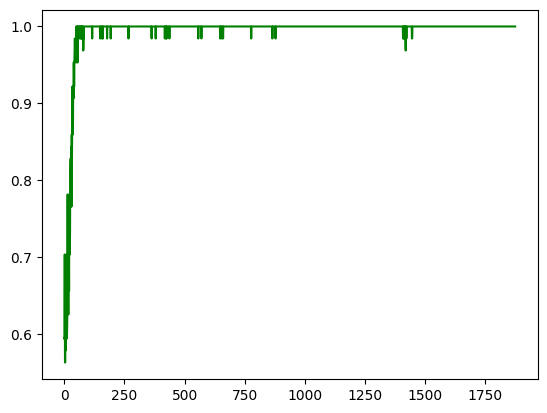

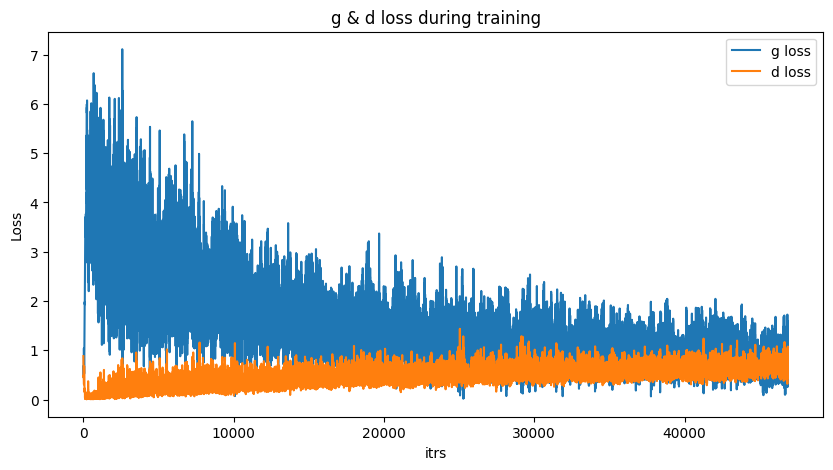

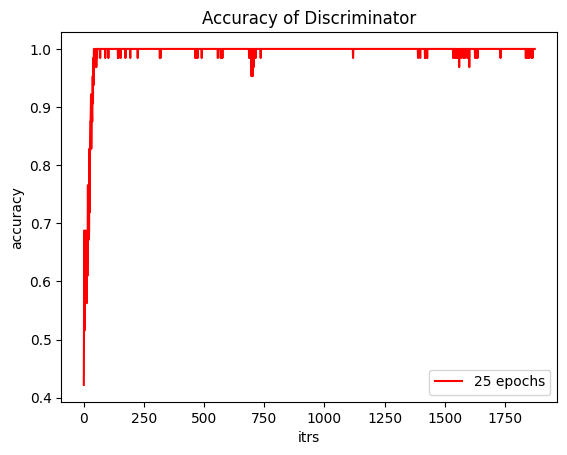

In [74]:
plt.figure(figsize=(10, 5))
colors = ['blue', 'green', 'red']
for index, epochs in enumerate([1, 10, 25]):
    accuracies = accuracy_discriminator(epochs, train_loader)
    plt.plot(accuracies, label=f"{epochs} epochs", color=colors[index])

plt.title("Accuracy of Discriminator")
plt.xlabel("itrs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Epoch [1/1], Step [1800/1875], D Loss: 0.1285, G Loss: 2.8917
Training finished.


<Figure size 1000x500 with 0 Axes>

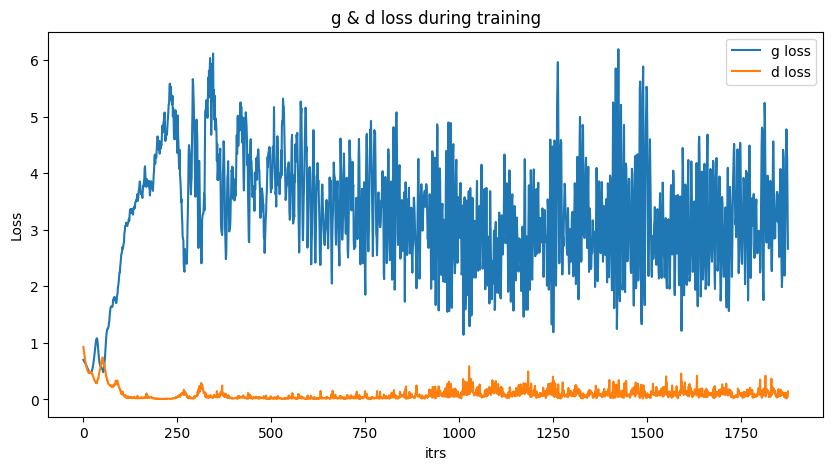

Epoch [1/10], Step [1800/1875], D Loss: 0.0457, G Loss: 2.7483
Epoch [2/10], Step [1800/1875], D Loss: 0.2534, G Loss: 4.5438
Epoch [3/10], Step [1800/1875], D Loss: 0.2601, G Loss: 3.4388
Epoch [4/10], Step [1800/1875], D Loss: 0.2256, G Loss: 2.0661
Epoch [5/10], Step [1800/1875], D Loss: 0.3323, G Loss: 2.1674
Epoch [6/10], Step [1800/1875], D Loss: 0.2996, G Loss: 2.2143
Epoch [7/10], Step [1800/1875], D Loss: 0.2834, G Loss: 1.8161
Epoch [8/10], Step [1800/1875], D Loss: 0.4602, G Loss: 1.2246
Epoch [9/10], Step [1800/1875], D Loss: 0.4693, G Loss: 1.1466
Epoch [10/10], Step [1800/1875], D Loss: 0.4062, G Loss: 1.2601
Training finished.


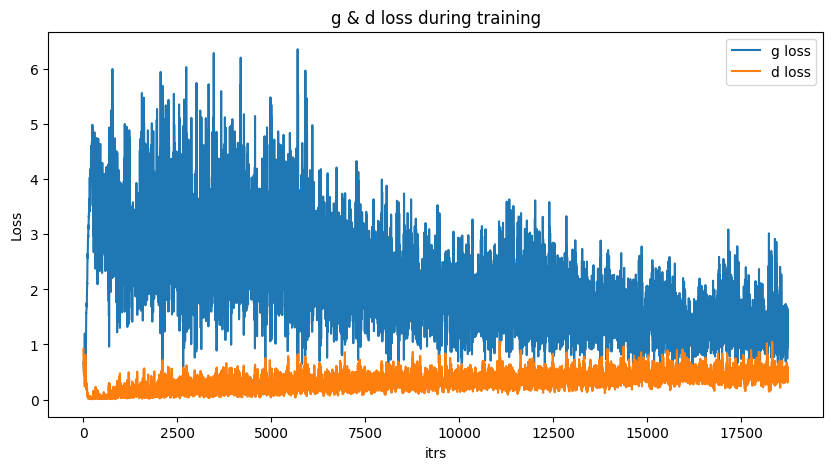

Epoch [1/25], Step [1800/1875], D Loss: 0.1047, G Loss: 3.6041
Epoch [2/25], Step [1800/1875], D Loss: 0.1748, G Loss: 2.8850
Epoch [3/25], Step [1800/1875], D Loss: 0.1718, G Loss: 3.1065
Epoch [4/25], Step [1800/1875], D Loss: 0.2597, G Loss: 2.2378
Epoch [5/25], Step [1800/1875], D Loss: 0.5184, G Loss: 1.0660
Epoch [6/25], Step [1800/1875], D Loss: 0.2415, G Loss: 1.4796
Epoch [7/25], Step [1800/1875], D Loss: 0.2951, G Loss: 1.6873
Epoch [8/25], Step [1800/1875], D Loss: 0.5861, G Loss: 0.8450
Epoch [9/25], Step [1800/1875], D Loss: 0.3800, G Loss: 1.1136
Epoch [10/25], Step [1800/1875], D Loss: 0.4171, G Loss: 1.2987
Epoch [11/25], Step [1800/1875], D Loss: 0.4584, G Loss: 1.3160
Epoch [12/25], Step [1800/1875], D Loss: 0.4384, G Loss: 1.3324
Epoch [13/25], Step [1800/1875], D Loss: 0.5154, G Loss: 1.4931
Epoch [14/25], Step [1800/1875], D Loss: 0.5351, G Loss: 1.0224
Epoch [15/25], Step [1800/1875], D Loss: 0.3419, G Loss: 1.5769
Epoch [16/25], Step [1800/1875], D Loss: 0.4792, 

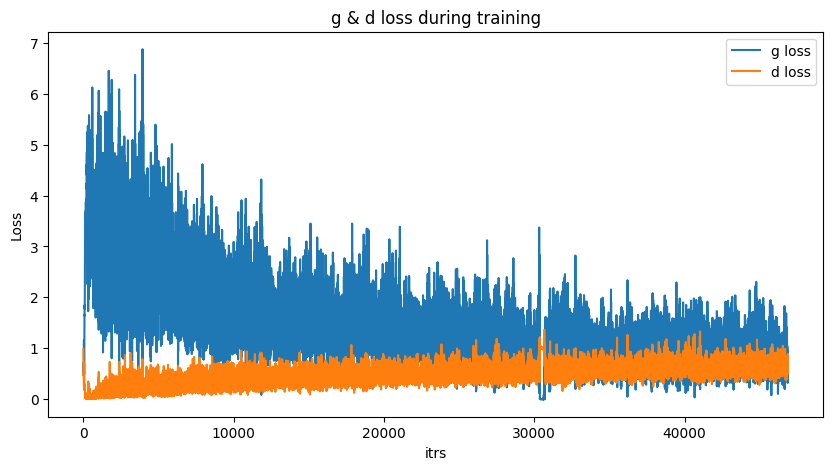

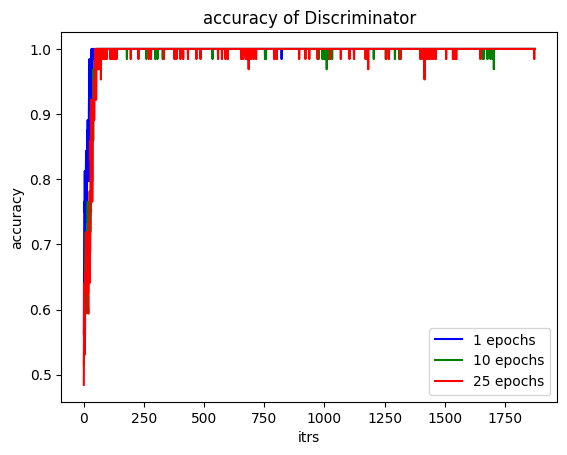

In [75]:
plt.figure(figsize=(10, 5))
colors = ['blue', 'green', 'red']

all_accuracies = []   
for index, epochs in enumerate([1, 10, 25]):
    accuracies = accuracy_discriminator(epochs, train_loader)
    all_accuracies.append(accuracies)   

for index, accuracies in enumerate(all_accuracies):
    plt.plot(accuracies, label=f"{epochs_to_train[index]} epochs", color=colors[index])

plt.title("accuracy of Discriminator")
plt.xlabel("itrs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

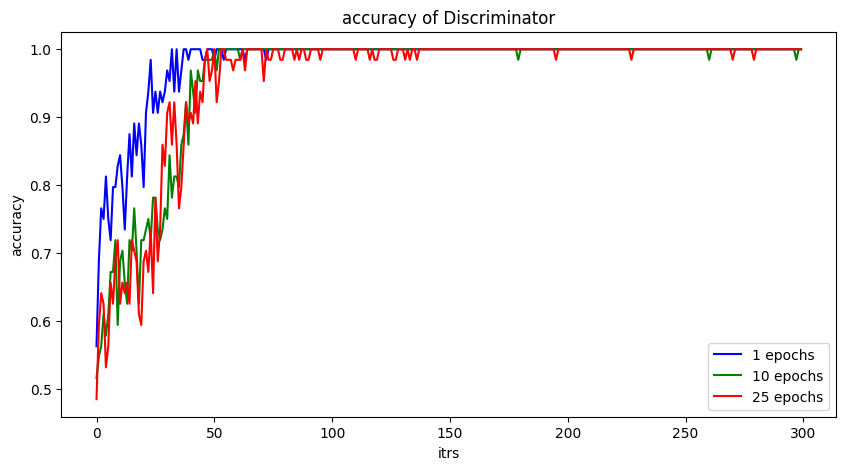

In [82]:
plt.figure(figsize=(10, 5))
colors = ['blue', 'green', 'red']

for index, accuracies in enumerate(all_accuracies):
    plt.plot(accuracies[:300], label=f"{epochs_to_train[index]} epochs", color=colors[index])

plt.title("accuracy of Discriminator")
plt.xlabel("itrs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

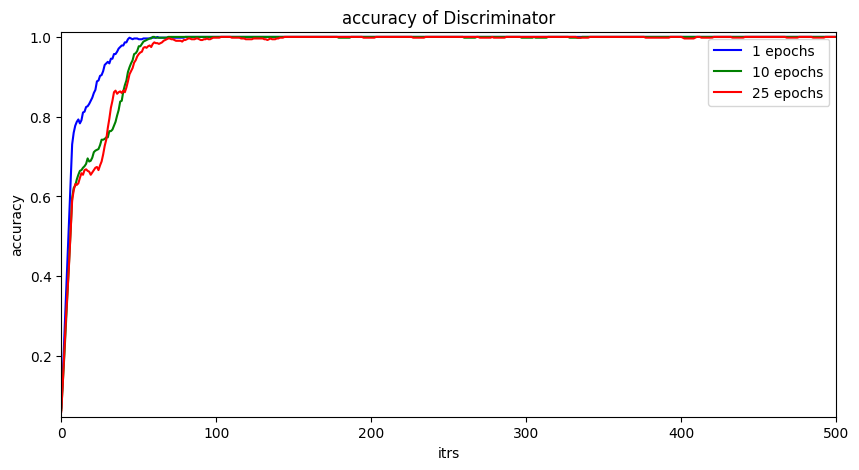

In [119]:
#moving avg accuracy plot

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size)

plt.figure(figsize=(10, 5))
colors = ['blue', 'green', 'red']
window_size = 8

for index, accuracies in enumerate(all_accuracies):
    ma_accuracies = moving_average(accuracies, window_size)
    plt.plot(ma_accuracies[:500], label=f"{epochs_to_train[index]} epochs", color=colors[index])

plt.xlim(0, len(ma_accuracies[:500]))
plt.ylim(min(ma_accuracies[:500]), max(ma_accuracies[:500]))
x_offset = 0.01
y_offset = 0.013
plt.xlim(-x_offset, 500 + x_offset)
plt.ylim(min(ma_accuracies[:500]) - y_offset, max(ma_accuracies[:500]) + y_offset)

plt.title("accuracy of Discriminator")
plt.xlabel("itrs")
plt.ylabel("accuracy")
plt.legend()
plt.show()